In [1]:
#Importing libraries that will be useful
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.io import imread
import keras
from keras import Input, Model
from keras.layers import Activation, Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential, load_model
from keras.metrics import Accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling
import pickle
import tensorflow as tf
Adam = tf.keras.optimizers.Adam
Xception = tf.keras.applications.Xception
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
warnings.filterwarnings("ignore")

# Introduction

The Breast Cancer Histopathological Image Classification (BreakHis) is  composed of 7909 microscopic images of breast tumor tissue collected from 82 patients using different magnifying factors (40X, 100X, 200X, and 400X).  

Each image is labeled according to its main category (Benign/Malignant) and its subcategory (A/F/PT/TA/PC/DC/LC/MC).  

In this work, I will focus on the subcategory and develop a CNN that performs multiclass classification

In [3]:
#Load the DataFrame
df = pd.read_csv("Folds.csv")

#Create a Dictionary for converting the labels in long form to shorthand
class_map = {"adenosis": "A",
           "fibroadenoma": "F", 
           "phyllodes_tumor": "PT", 
           "tubular_adenoma": "TA", 
          
           "ductal_carcinoma": "DC",
           "papillary_carcinoma": "PC" , 
           "lobular_carcinoma": "LC", 
           "mucinous_carcinoma": "MC"}

#Rename the filename column to path
df = df.rename(columns = {"filename":"path"})

#Data contains folds, drop the duplicates
df = df.drop_duplicates(subset=['path'],keep='first')

# Data Preparation and Data Exploration

The DataFrame path columns contains the path of every image in the dataset. Due the the main category of benign/malignant and the subcategories, the dataset is nested in a way that is not convenient for the task.  

I will be moving the images to a new folder and creating a new DataFrame convenient for classification of the subcategories.



In [4]:
#Obtaining the filename from the path column
df['filename'] = df['path'].apply(lambda x:x.split("/")[-1])

#Creating a new colummn for the label of the image
df["label"] = df['path'].apply(lambda x: class_map[x.split("/")[5]])

### There are 7909 images in this dataset

In [5]:
print(len(df))
df.head()


7909


fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

                         filename label  
0  SOB_B_A-14-22549AB-100-001.png     A  
1  SOB_B_A-14-22549AB-100-002.png     A  
2  SOB_B_A-14-22549AB-100-003.png     A  
3  SOB_B_A-14-22549AB-100-004.png     A  
4  SOB_B_A-14-22549AB-100-005.png     A

## Inspecting the images

There are 8 subcategories for the microscopic images of breast tumor tissue. The sampled images show how the images differ depending the level of magnification from 40x, 100x, 200x to 400x.  
The first 4 categories are considered 'benign' tumors, dispalyed in the first 4 rows. The last 4 rows show the microscopic images of malignant tumors.



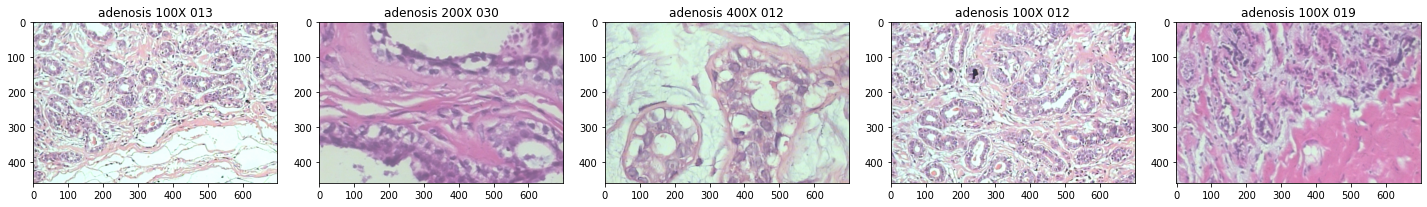

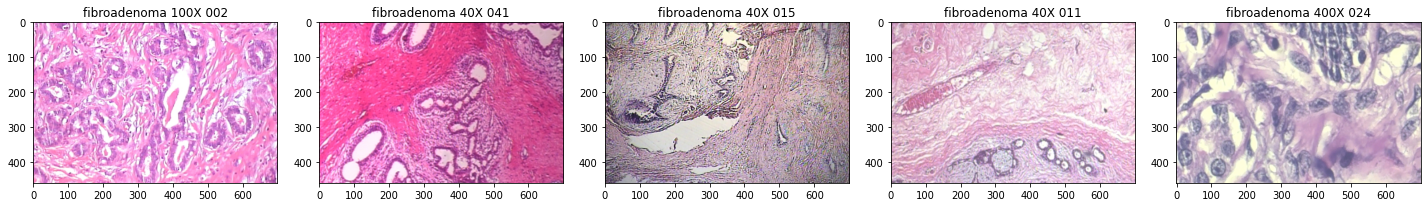

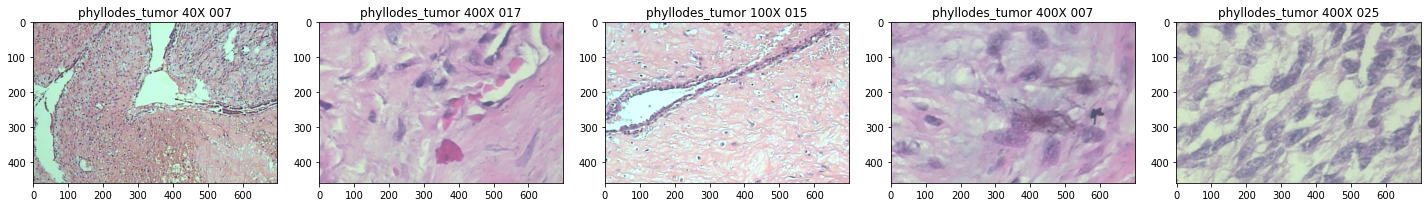

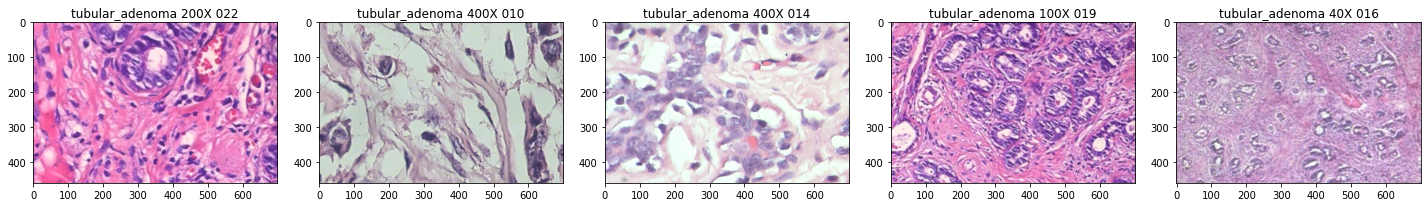

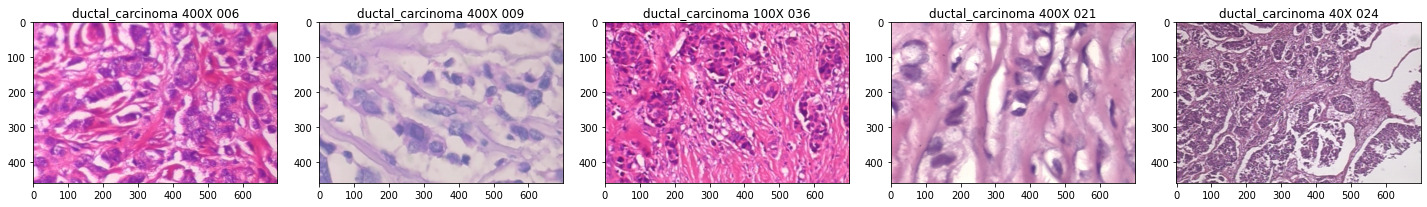

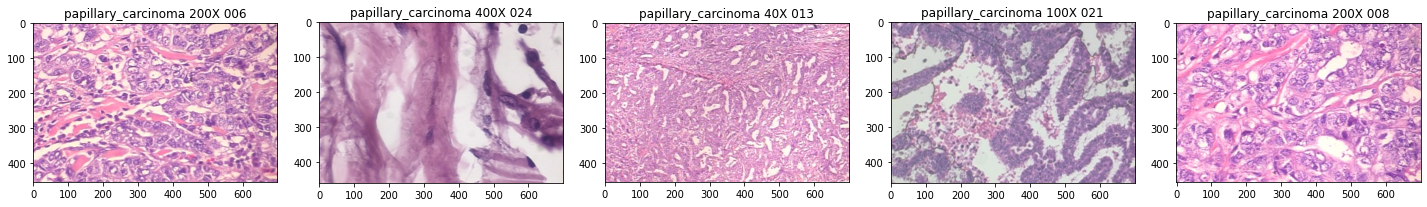

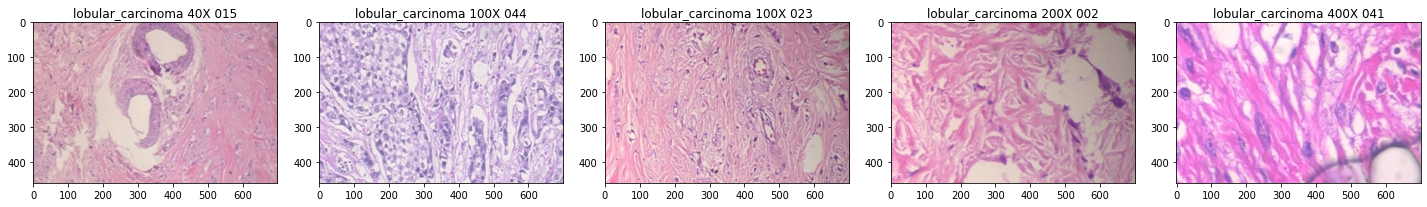

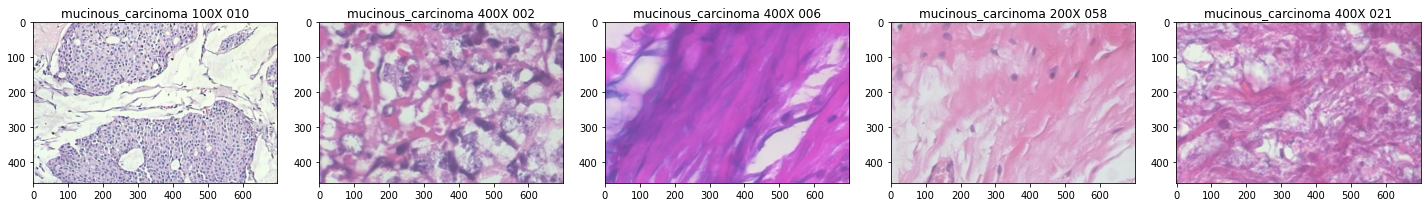

In [6]:
#Looping through the class labels and sampling 5 random images of each class from the dataset

for key, val in class_map.items():
    sample = np.random.choice(df[df.label==val].index.values, size=5, replace=False)



    fig, ax = plt.subplots(1,5,figsize=(20,10))
    fig.tight_layout()

    for j in range(5):
        idx = sample[j]
        p = "BreaKHis_v1/" + df.loc[idx, "path"]
        image = imread(p)
        ax[j].set_title(key + " " + p.split('-')[-2] + "X " + p.split('-')[-1][:3])
        ax[j].imshow(image)
        ax[j].grid(False)


Create a new Data folder to aggregate all the images and move the images to this location. If Data.rar was downloaded, no need to run cells that are blacked out. Otherwise, activate these cells.

Creating a new Dataframe with two columns, the image file name and the label for that image

Split the dataset twice, once into the training data and the withheld test data.  
Split the training data into the trainig data and the validation data.

In [8]:
train_and_val_data, test_data = train_test_split(df, test_size = 0.1, random_state = 42)
train_data, val_data = train_test_split(train_and_val_data, test_size = 0.1, random_state = 42)

Create the folders where the training images, validation images and test images will be moved to.

Move each image into the correct location for training, validation and testing data

# Frequency of each category 
The frequency distribution of training, validation data and test data is shown.  
The data is not balanced, there is much more occurence of the 'DC' (ductal carcinoma) category in all the datasets.

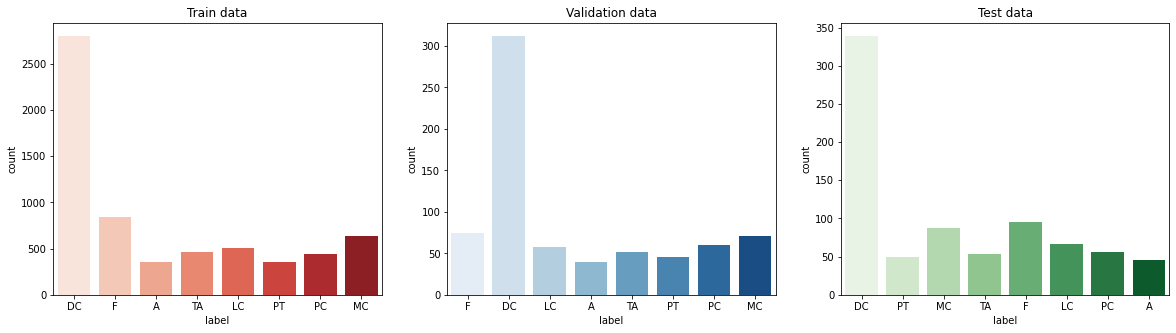

In [9]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_data.label, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(val_data.label, ax=ax[1], palette="Blues")
ax[1].set_title("Validation data")
sns.countplot(test_data.label, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

To mitigate this issue, I decided to try upsampling the images of all categories that are not 'DC' in the dataset to the same amount as that of 'DC'.

To achieve this, images from other categories were simply sampled at random more frequently to balance out the dataset.

In [10]:
train_DC = train_data[train_data['label'] == 'DC']
train_other_upsamples = []
for val in class_map.values():
    if val != 'DC': 
        train_other = train_data[train_data['label'] == val]      
        train_other_upsample = resample(train_other, n_samples = len(train_DC), 
                                            random_state = 42, replace = True)
        train_other_upsamples.append(train_other_upsample)
train_data = pd.concat([train_DC] + train_other_upsamples)

As can be seen from the figure below, the training data was balanced to have the same number of samples for each category.  
The number of samples in the validation and test data was not touched.

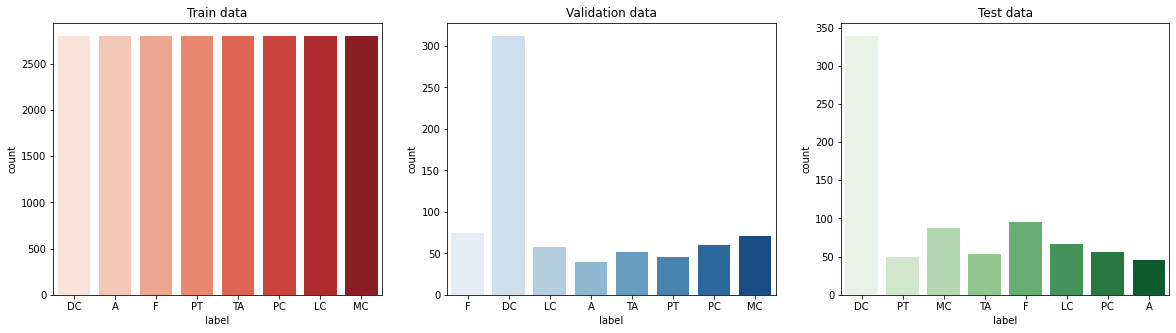

In [11]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(train_data.label, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(val_data.label, ax=ax[1], palette="Blues")
ax[1].set_title("Validation data")
sns.countplot(test_data.label, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

# Data Augmentation

To improve the performance of the model, the data was augmented with rotations, shearing, changing magnification, horizontal and vertical flips.  
This is so that the model will be robust to these common image perturbations.

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [13]:
train = datagen.flow_from_directory("Data/train/",target_size=(128,128),batch_size = 32, class_mode="categorical")
val = datagen.flow_from_directory("Data/validation/", target_size=(128,128), batch_size=32, class_mode="categorical")

Found 6406 images belonging to 8 classes.
Found 712 images belonging to 8 classes.


# Model
The model is a standard CNN with four convolutional layers followed by three Densely connected layers where the final layer will contain 8 outputs for each of the categories.  


In [14]:
inputs = Input(shape=(128, 128, 3))
x = Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.2)(x) 
x = Conv2D(filters = 256, kernel_size = (3,3), padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Dropout(0.2)(x) 
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) 

x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(len(class_map))(x)

outputs = Activation('softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [15]:
model.compile(loss = "categorical_crossentropy",
             optimizer = Adam(),
             metrics = ["accuracy"])

# Model training

In [158]:
#history = model.fit(train, validation_data=val, epochs=20 , verbose = 1)

Epoch 1/20
201/201 [==============================] - 157s 779ms/step - loss: 1.6724 - accuracy: 0.4579 - val_loss: 1.6532 - val_accuracy: 0.4677
Epoch 2/20
201/201 [==============================] - 172s 855ms/step - loss: 1.5499 - accuracy: 0.5003 - val_loss: 1.5102 - val_accuracy: 0.5056
Epoch 3/20
201/201 [==============================] - 168s 837ms/step - loss: 1.5156 - accuracy: 0.5019 - val_loss: 1.4831 - val_accuracy: 0.5042
Epoch 4/20
201/201 [==============================] - 176s 878ms/step - loss: 1.4963 - accuracy: 0.5012 - val_loss: 1.8000 - val_accuracy: 0.4242
Epoch 5/20
201/201 [==============================] - 161s 801ms/step - loss: 1.5167 - accuracy: 0.4966 - val_loss: 1.5551 - val_accuracy: 0.4677
Epoch 6/20
201/201 [==============================] - 168s 837ms/step - loss: 1.4544 - accuracy: 0.5144 - val_loss: 1.4311 - val_accuracy: 0.5126
Epoch 7/20
201/201 [==============================] - 167s 831ms/step - loss: 1.4119 - accuracy: 0.5264 - val_loss: 1.3731 -

In [16]:
model = keras.models.load_model("model_1")
history = pickle.load(open('model_history', "rb"))

## Plotting Train accuracy and validation accuracy

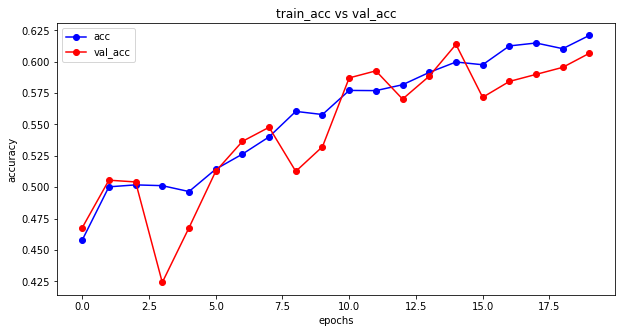

In [17]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(10,5))

    plt.plot(history['accuracy'],'bo-', label = "acc")
    plt.plot(history['val_accuracy'], 'ro-', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
def plot_loss(history):
    fig = plt.figure(figsize=(10,5))

    plt.plot(history['loss'],'bo-', label = "loss")
    plt.plot(history['val_loss'], 'ro-', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    
plot_accuracy(history)

## Plotting Train loss and validation loss

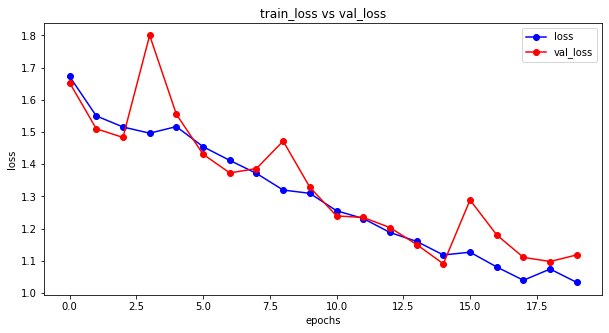

In [18]:
plot_loss(history)

## Analysis of Error

In [19]:
test = datagen.flow_from_directory("Data/test/", target_size=(128,128), 
                                   class_mode="categorical", batch_size=1, shuffle=False)
predictions = model.evaluate(test)
prediction_labels = np.argmax(model.predict(test), axis = 1)

Found 791 images belonging to 8 classes.
791/791 [==============================] - 15s 12ms/step - loss: 1.1138 - accuracy: 0.6094


Text(0.5, 1.0, 'Confusion Matrix')

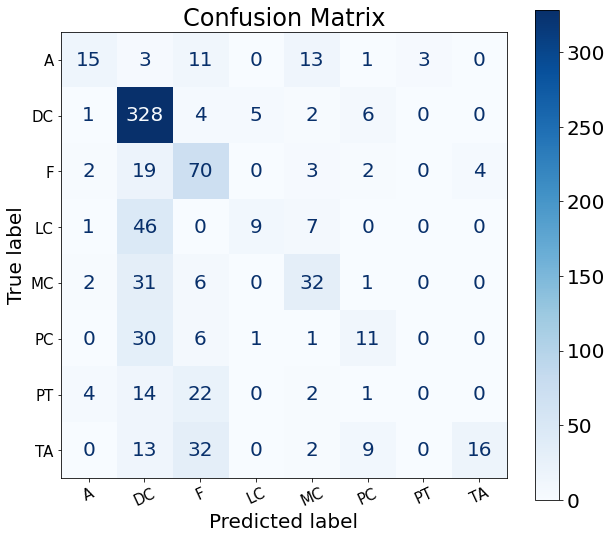

In [20]:
cm = confusion_matrix(test.labels, prediction_labels)

plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20

display_c_m = ConfusionMatrixDisplay(cm, display_labels=test.class_indices)
display_c_m.plot(cmap='Blues', xticks_rotation=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Confusion Matrix', fontsize=24)

## Using a pretrained model

Here I will attemp to use the Xception model as a pretrained model and train on the top layers for the same number of iterations and see if a better classification accuracy can be obtained.

In [21]:
base_model = Xception(
    weights="imagenet",  
    input_shape=(128, 128, 3),
    include_top=False,
)  

base_model.trainable = False

inputs = Input(shape=(128, 128, 3))
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  

x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(len(class_map))(x)


outputs = Activation('softmax')(x)
model = Model(inputs, outputs)
model.summary()

83697664/83683744 [==============================] - 10s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
___________________________________________________________

In [22]:
model.compile(loss = "categorical_crossentropy",
             optimizer = Adam(),
             metrics = ["accuracy"])

In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [24]:
train = datagen.flow_from_directory("Data/train/",target_size=(128,128),batch_size = 32, class_mode="categorical")
val = datagen.flow_from_directory("Data/validation/", target_size=(128,128), batch_size=32, class_mode="categorical")

Found 6406 images belonging to 8 classes.
Found 712 images belonging to 8 classes.


In [172]:
#history = model.fit(train, validation_data=val, epochs=20 , verbose = 1)

Epoch 1/20
201/201 [==============================] - 224s 1s/step - loss: 1.5391 - accuracy: 0.4769 - val_loss: 1.4654 - val_accuracy: 0.4747
Epoch 2/20
201/201 [==============================] - 221s 1s/step - loss: 1.3555 - accuracy: 0.5237 - val_loss: 1.3738 - val_accuracy: 0.5295
Epoch 3/20
201/201 [==============================] - 226s 1s/step - loss: 1.2874 - accuracy: 0.5439 - val_loss: 1.3442 - val_accuracy: 0.5435
Epoch 4/20
201/201 [==============================] - 231s 1s/step - loss: 1.2234 - accuracy: 0.5707 - val_loss: 1.2697 - val_accuracy: 0.5562
Epoch 5/20
201/201 [==============================] - 225s 1s/step - loss: 1.1698 - accuracy: 0.5821 - val_loss: 1.2586 - val_accuracy: 0.5618
Epoch 6/20
201/201 [==============================] - 234s 1s/step - loss: 1.1545 - accuracy: 0.5898 - val_loss: 1.1199 - val_accuracy: 0.5927
Epoch 7/20
201/201 [==============================] - 244s 1s/step - loss: 1.1147 - accuracy: 0.6001 - val_loss: 1.1369 - val_accuracy: 0.5758

In [43]:
model = keras.models.load_model("model_xception")
history = pickle.load(open('xception_history', "rb"))

It seems that model only performs slightly better than the standard cnn model built above. Perhaps, more epochs is needed or the weights in other layers need to be adjusted too

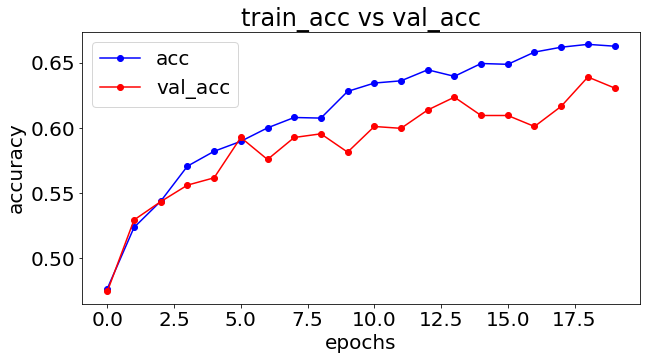

In [26]:
plot_accuracy(history)


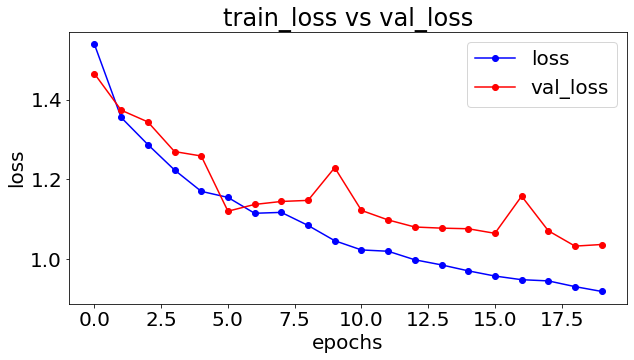

In [27]:
plot_loss(history)

In [28]:
test = datagen.flow_from_directory("Data/test/", target_size=(128,128), 
                                   class_mode="categorical", batch_size=1, shuffle=False)
predictions = model.evaluate(test)
prediction_labels = np.argmax(model.predict(test), axis = 1)

Found 791 images belonging to 8 classes.
791/791 [==============================] - 11s 13ms/step - loss: 1.0351 - accuracy: 0.6372


Text(0.5, 1.0, 'Confusion Matrix')

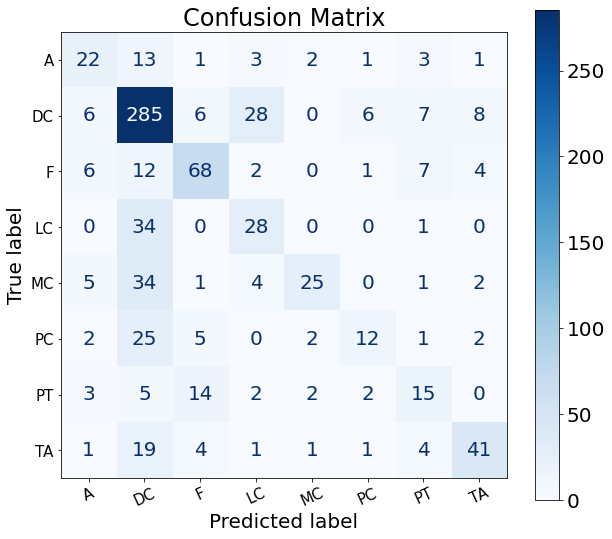

In [29]:
cm = confusion_matrix(test.labels, prediction_labels)

plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20

display_c_m = ConfusionMatrixDisplay(cm, display_labels=test.class_indices)
display_c_m.plot(cmap='Blues', xticks_rotation=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Confusion Matrix', fontsize=24)

# Road to Achieving higher image classification accuracy

In [30]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

train = datagen.flow_from_directory("Data/train/",target_size=(224,224),batch_size = 32, class_mode="categorical")
val = datagen.flow_from_directory("Data/validation/", target_size=(224,224), batch_size=32, class_mode="categorical")

Found 6406 images belonging to 8 classes.
Found 712 images belonging to 8 classes.


In [31]:
EfficientNetB0 = tf.keras.applications.EfficientNetB0

EfficientNet assumes an input image size of 224 by 224  
Will use EfficientNetB0 model pretrained with imagenet weights and train on the top layer

In [32]:
inputs = Input(shape=(224, 224, 3))
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

model.trainable = False

x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)

x = Dropout(0.2, name="top_dropout")(x)
outputs = Dense(len(class_map), activation="softmax", name="pred")(x)


model = Model(inputs, outputs)
model.summary()


model.compile(loss = "categorical_crossentropy",
             optimizer = Adam(),
             metrics = ["accuracy"])

16719872/16705208 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________

Instead of running for a fixed number of epochs, training will terminate when validation loss does not improve for 3 epochs consecutively

In [33]:
model = keras.models.load_model("model_efficient")
history = pickle.load(open('efficient_history', "rb"))

## Fine Tuning Model
From the above training procedure, it can be observed that loss reduction has stagnated. Instead of just training on the last layer, perhaps training on the top 20 layers will help improve the validation loss. Will use a reduced learning rate for fine tuning. It could also be possible that 3 consecutive epochs is too little, will increase to 6.

In [34]:
for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

model.compile(loss = "categorical_crossentropy",
             optimizer = Adam(1e-4),
             metrics = ["accuracy"])



Instead of running for a fixed number of epochs, training will terminate when validation loss does not improve for 6 epochs consecutively

In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
history = model.fit(train, validation_data=val, epochs=300 , callbacks = [callback], verbose = 1)

Epoch 1/300
201/201 [==============================] - 307s 1s/step - loss: 0.9253 - accuracy: 0.6716 - val_loss: 0.8706 - val_accuracy: 0.7051
Epoch 2/300
201/201 [==============================] - 243s 1s/step - loss: 0.8693 - accuracy: 0.6886 - val_loss: 0.8055 - val_accuracy: 0.6952
Epoch 3/300
201/201 [==============================] - 244s 1s/step - loss: 0.7924 - accuracy: 0.7070 - val_loss: 0.7572 - val_accuracy: 0.7331
Epoch 4/300
201/201 [==============================] - 244s 1s/step - loss: 0.7360 - accuracy: 0.7246 - val_loss: 0.7147 - val_accuracy: 0.7570
Epoch 5/300
201/201 [==============================] - 244s 1s/step - loss: 0.6823 - accuracy: 0.7463 - val_loss: 0.6649 - val_accuracy: 0.7598
Epoch 6/300
201/201 [==============================] - 245s 1s/step - loss: 0.6792 - accuracy: 0.7474 - val_loss: 0.6653 - val_accuracy: 0.7725
Epoch 7/300
201/201 [==============================] - 244s 1s/step - loss: 0.6278 - accuracy: 0.7666 - val_loss: 0.6053 - val_accuracy:

In [37]:
model = keras.models.load_model("model_efficient_full")
history1 = pickle.load(open('efficient_history', "rb"))  
history2 = pickle.load(open('efficient_history_full', "rb"))

# Results 

Final model has a classification accuracy of 82.55% on the test set which is considerably better than the two previous models

In [38]:
test = datagen.flow_from_directory("Data/test/", target_size=(224,224), 
                                   class_mode="categorical", batch_size=1, shuffle=False)
predictions = model.evaluate(test)
prediction_labels = np.argmax(model.predict(test), axis = 1)

Found 791 images belonging to 8 classes.
791/791 [==============================] - 13s 15ms/step - loss: 0.4782 - accuracy: 0.8217


In [39]:
history = {}
for key, value in history1.items():
    history[key] = history1[key] + history2[key]

From both graphs, it seems that the initial training does reach a bottleneck very quickly. 
The capacity of the model where the top 20 layers are trainable is much higher.  
As expected from the second part of the training, the training loss continuously decreases and accuracy continuously increases. But after a certain point, validation loss and accuracy begins to stagnate and fall behind.

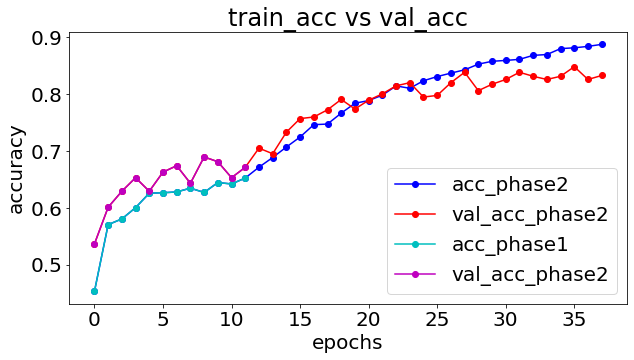

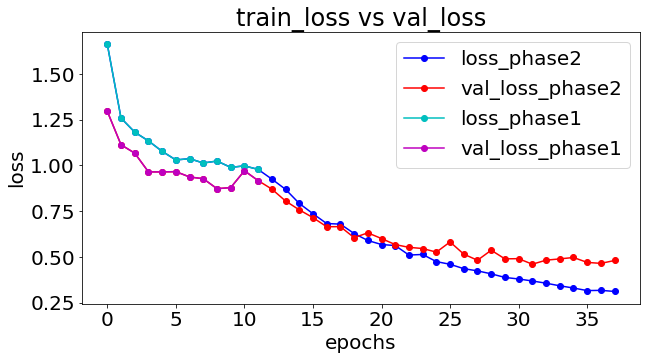

In [40]:
fig = plt.figure(figsize=(10,5))

plt.plot(history['accuracy'],'bo-', label = "acc_phase2")
plt.plot(history['val_accuracy'], 'ro-', label = "val_acc_phase2")
plt.plot(history1['accuracy'],'co-', label = "acc_phase1")
plt.plot(history1['val_accuracy'], 'mo-', label = "val_acc_phase2")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

fig = plt.figure(figsize=(10,5))

plt.plot(history['loss'],'bo-', label = "loss_phase2")
plt.plot(history['val_loss'], 'ro-', label = "val_loss_phase2")
plt.plot(history1['loss'],'co-', label = "loss_phase1")
plt.plot(history1['val_loss'], 'mo-', label = "val_loss_phase1")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

The Confusion Matrix seems much cleaner, the model performs pretty well at classifying all classes. Given that the test set and original training set is unbalanced, the model does not seem to have a significant bias towards simply predicting images as DC.  
The biggest errors the model makes is where the true label is LC, MC, PC but the model has a tendency to predict them as DC. This makes sense since they are all carcinomas, part of the malignant category and may be difficult to distinguish from each other. 

Text(0.5, 1.0, 'Confusion Matrix')

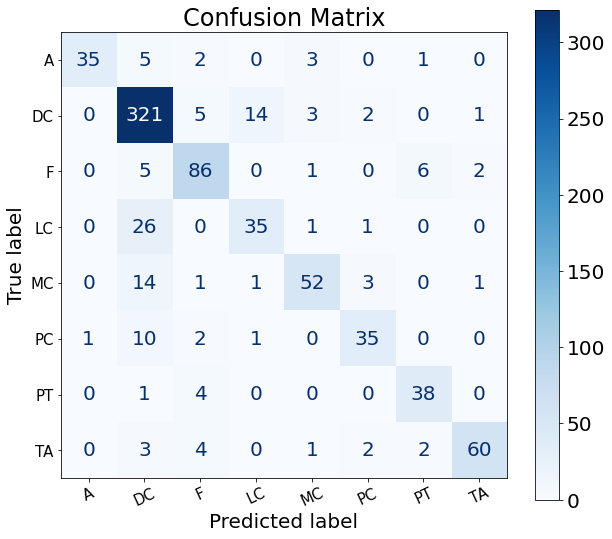

In [41]:
cm = confusion_matrix(test.labels, prediction_labels)

plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20

display_c_m = ConfusionMatrixDisplay(cm, display_labels=test.class_indices)
display_c_m.plot(cmap='Blues', xticks_rotation=25)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('Confusion Matrix', fontsize=24)